In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import csr_matrix
from starter_code import construct_system
import matplotlib.animation as animation

In [2]:
def Cool_can(N_r, t_initial, t_final, t_step, T0=None):
    """
    Parameters that are unchanged are set internally
    User control can be implemented as needed
    
    
    """
    def T_prime(t, T, A, b, rho, c_p):
        return (b - A@T)/rho/c_p
    
    h = 0.12
    r = 0.03
    d = 2*r

    kfun = lambda r, z : 0.58 #[W m-1 K-1] @ 10 C
    qppp = lambda r, z : 0 # no heat gen in can
    
    k = kfun(0,0)
    mu = 17.916e-4 # {Pa*s}
    rho = 1000 # ~{kg/m^3}
    w = np.pi*d # {m/s}
    c_p = 4.18 * 1000 # {J/kg*K}
    
    Re = rho * w * d / mu
    Pr = c_p * mu / k
    Nu = 0.133 * Re**(2/3) * Pr**(1/3)
    HTC = Nu*k/d
    T_oo = 0 # {C}
    
    #set Boundary Conditions
    BC_z = ('robin', HTC, T_oo)
    BC_r_top = ('robin', HTC, T_oo)
    BC_r_bottom = ('robin', HTC, T_oo)

    #discritization
    #N_r = 30
    N_z = int((h/r)*N_r) #equal delta in h and r directions

    r_edge = np.linspace(0, r, N_r+1)
    z_edge = np.linspace(0, h, N_z+1)

    r_center = (r_edge[:-1]+r_edge[1:])/2
    z_center = z_edge[:-1]+z_edge[1:]/2

    A, b = construct_system(r_center, z_center, kfun, qppp,
                        BC_z, BC_r_top, BC_r_bottom)
    A_spc = csr_matrix(A)
    
    #Logic to set initial temperature using assummed value, given value, or map from
    try:
        if T0 == None: T0 = 35
    except: pass 
    if type(T0) == int: T0 = T0 * np.ones(A.shape[0]) # {deg C}
    elif type(T0) == np.ndarray: T0 = T0.flatten()
    else: raise "Missing Initial Temperature Map"

    t_eval = np.arange(t_initial, t_final+t_step, t_step, dtype=np.float64) # Evaluate at times listed (t_final is last in the list)
    
    sol = solve_ivp(T_prime, [t_initial, t_final+t_step], T0, 
                    args=(A_spc, b, rho, c_p),
                    t_eval=t_eval,
                    method='BDF')

    
    r_weights = np.array([r_edge[-(i+1)]**2 - r_edge[-(i+2)]**2 for i in range(N_r)])
    r_weights_norm = np.flip(r_weights/sum(r_weights))
    T_bar = np.zeros_like(t_eval)
    for i in range(len(T_bar)):
        T_bar[i] = sum(sum(sol.y[:,i].reshape((N_z, N_r))*r_weights_norm))/N_z

    return t_initial, t_final, T_bar, sol.y.T.reshape((-1, N_z, N_r))
    

In [3]:
def valCross(ind,dep,ths):
    """
    Finds ths in ind and interpolates to find dep(ths) assuming ind is decending
    """
    for i in range(len(ind)):
        if ind[i] < ths:
            return (dep[i-1]-dep[i])/(ind[i-1]-ind[i])*(ths-ind[i]) + dep[i]
        elif ind[i] == ths:
            return dep[i]
    raise ValueError("Threshold was not crossed by ind.")


In [12]:
def genPlots(vals, errs, N_r):
    """
    Generates:
    A two-panel plot:
        - Top: Time at which temperature threshold is passed values vs. N_r
        - Bottom: Relative errors vs. N_r

    Parameters:
    - vals: Times values from convergence test
    - errs: Relative errors of the temperature values
    - N_r: Number of mesh points
 
    """
    # --- 1. Plot temperature and relative error on shared x-axis ---
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), gridspec_kw={'height_ratios': [2, 1]})
    
    # Top plot: Temperature values
    ax1.plot(N_r, vals, marker='o', color='steelblue', label='Temperature')
    ax1.set_ylabel("Time (s)")
    ax1.set_title("Convergence Analysis")
    ax1.grid(True)
    ax1.legend()

    # Bottom plot: Relative errors
    ax2.semilogy(N_r, errs, marker='s', color='darkorange', label='Relative Error')
    ax2.set_xlabel("Number of Mesh Points (N_r)")
    ax2.set_ylabel("Relative Error")
    ax2.grid(True)
    ax2.legend()


    plt.tight_layout()
    plt.show()

In [20]:
def converganceTest(N_r_initial=2, t_initial=0, t_final=900, t_step=20, diff_percent=0.1, max_itr=20, gen_plots=False):
    
    T_thres = 10 #deg C set by problem statement
    extend_mesh = 2 #mesh density is sacled by value after each iteration
    t_extend = 200 #if the threshold temp is not reached, t_final is extended and T is recalculated
    N_r = [N_r_initial]

    rel_diff = [] #
    t_cross = [1] #Time at which the temperature threshold is crossed
    
    for i in range(max_itr):
        t_start, t_end, T_bar, T_map = Cool_can(N_r[i], t_initial,
                                                         t_final, t_step)
        while T_bar[-1] > T_thres:
            print("Iteration {}: threshold not crossed...increasing time to {}s".format(i,t_end+t_extend))
            t_start, t_end, T_bar, T_map = Cool_can(N_r[i], t_end, 
                                                             t_end+t_extend, t_step,
                                                             T0=T_map[-1])
        t_eval = np.arange(t_start, t_end+t_step, t_step, dtype=float)
        t_cross.append(valCross(T_bar,t_eval,T_thres))
        rel_diff.append((abs(t_cross[i+1]-t_cross[i])/t_cross[i]*100))
        if rel_diff[i] < diff_percent:
            print("System converged on step {} at N_r={}".format(i+1,N_r[-1]))
            print("The average temperature of the bevi reached {} C in {:.1f} seconds.".format(T_thres,t_cross[-1]))
            if gen_plots: genPlots(np.array(t_cross[1:]), np.array(rel_diff), N_r)
            return T_map

        N_r.append(N_r[-1] + extend_mesh)
        
    raise ValueError("Max number of iterations exceeded: value did not converge.")
    return None

Iteration 0: threshold not crossed...increasing time to 1100s
Iteration 0: threshold not crossed...increasing time to 1300s
Iteration 1: threshold not crossed...increasing time to 1100s
System converged on step 9 at N_r=18
The average temperature of the bevi reached 10 C in 876.5 seconds.


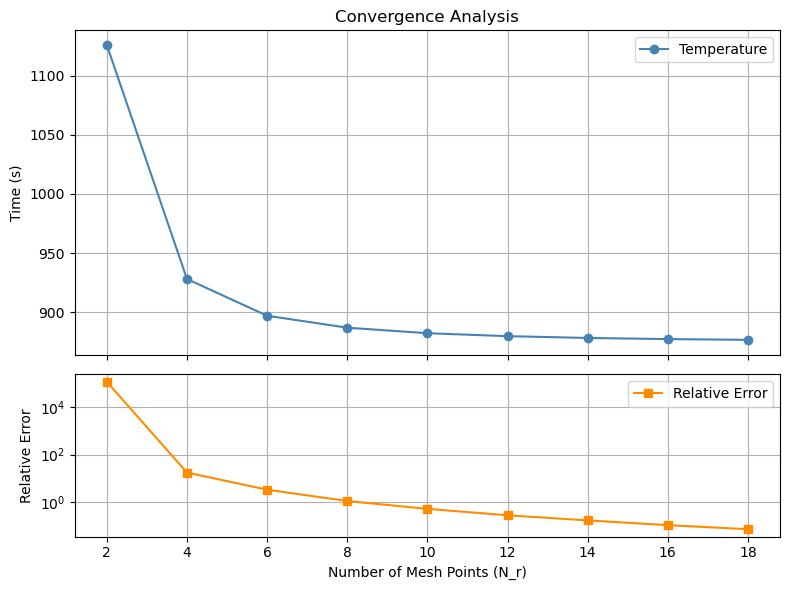

In [21]:
con_T_map = converganceTest(gen_plots=True)


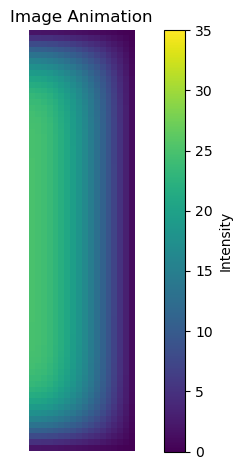

In [24]:
imgs = con_T_map
fig, ax = plt.subplots()

max_val = np.max(imgs)
im = ax.imshow(imgs[0], cmap='viridis', vmin=0, vmax=max_val)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Intensity")

def update(frame):
    im.set_data(imgs[frame])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(imgs), blit=True, interval=200)
ani.save("Temp_Animation.gif",writer='pillow')
plt.title("Image Animation")
plt.axis('off')
plt.tight_layout()
plt.show()